#### Afinn Lexicon

Using lexicons is a little bit of a different process since it is a list of predetermined scores for a large number of words. This means we should not perform stemming and we should not split the data before creating this feature.

In [1]:
import pandas as pd
import numpy as np
from afinn import Afinn
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from src.paths import TRANSFORMED_DATA_DIR
from src.split_and_tfidf import split_and_vect

In [2]:
# import our data
df = pd.read_parquet(TRANSFORMED_DATA_DIR / 'cleaned_sentiments.parquet')
df.head

,recommended,cleaned
0,1,Very good flight following an equally good fli...
1,1,An hours delay due to late arrival of the inco...
2,0,I booked through BA because Loganair dont have...
3,0,British airways lost bags in LHR then found th...
4,0,The check in process and reward loyalty progra...


In [5]:
# copy of data
df_copy = df.copy()

In [7]:
# afinn 
afinn = Afinn()

# apply it
df_copy['afinn'] = df_copy['cleaned'].apply(lambda x: afinn.score(x))
df_copy.head()

df_copy.head()

,recommended,cleaned,afinn
0,1,Very good flight following an equally good fli...,9.0
1,1,An hours delay due to late arrival of the inco...,2.0
2,0,I booked through BA because Loganair dont have...,-4.0
3,0,British airways lost bags in LHR then found th...,-6.0
4,0,The check in process and reward loyalty progra...,2.0


In [10]:
# correlation
correlation = df_copy[['recommended', 'afinn']].corr().iloc[0, 1]
print(correlation)

0.6157244819316255


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# dont include the afinn score yet because we will be doing a tfidf vectorizer on just the text data
X = df_copy['cleaned']
y = df_copy['recommended']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)


In [25]:
# vectorize the cleaned data
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words= 'english')

# fit transform X_train
X_train_vec = vectorizer.fit_transform(X_train)
# transform X_test
X_test_vec = vectorizer.transform(X_test)

In [26]:
from scipy.sparse import hstack
# convert afinn scores to a numpy array with 1 dim
afinn_train_scores = df_copy.loc[X_train.index, 'afinn'].values.reshape(-1, 1)
afinn_test_scores = df_copy.loc[X_test.index, 'afinn'].values.reshape(-1, 1)

# combine with hstack
X_train_full = hstack([X_train_vec, afinn_train_scores])
X_test_full = hstack([X_test_vec, afinn_test_scores])

In [16]:
df_copy.loc[X_train.index, 'afinn']

1860    21.0
3328    35.0
2739   -14.0
175      1.0
278     -6.0
        ... 
1130     2.0
1294    14.0
860     22.0
3506    13.0
3172     4.0
Name: afinn, Length: 3115, dtype: float64

In [27]:
# initialize
model = SGDClassifier()
model.fit(X_train_full, y_train)

# Making predictions
predictions = model.predict(X_test_full)

In [28]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       503
           1       0.87      0.78      0.82       276

    accuracy                           0.88       779
   macro avg       0.88      0.86      0.86       779
weighted avg       0.88      0.88      0.88       779



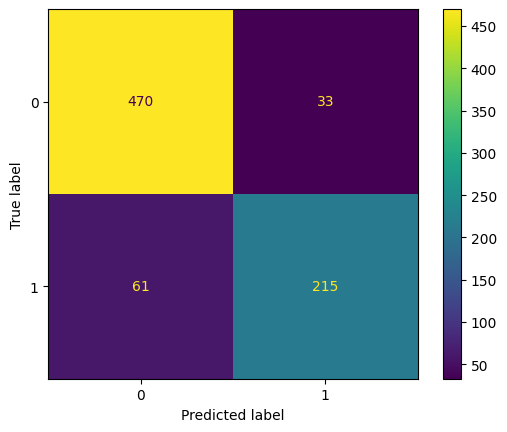

In [29]:
ConfusionMatrixDisplay.from_estimator(model, X_test_full, y_test)

In [30]:
# split by sentiments 
good_reviews = df.loc[df['recommended'] == 1]
bad_reviews = df.loc[df['recommended'] == 0]

In [31]:
good_reviews.head()

,recommended,cleaned
0,1,Very good flight following an equally good fli...
1,1,An hours delay due to late arrival of the inco...
11,1,Pretty good flight but still some small things...
12,1,Check in was fine but no priority fast track l...
19,1,This flight was British Airways at its very be...


In [35]:
good_reviews['review_length'] = good_reviews['cleaned'].apply(len)
bad_reviews['review_length'] = bad_reviews['cleaned'].apply(len)

C:\Users\ryans\AppData\Local\Temp\ipykernel_43168\2656471076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_reviews['review_length'] = good_reviews['cleaned'].apply(len)
C:\Users\ryans\AppData\Local\Temp\ipykernel_43168\2656471076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_reviews['review_length'] = bad_reviews['cleaned'].apply(len)


In [37]:
avg_good = good_reviews['review_length'].mean()
avg_good

727.4381017881706

In [38]:
avg_bad = bad_reviews['review_length'].mean()
avg_bad

956.4967213114754

In [45]:
df_length_added = df.copy()

In [46]:
df_length_added['len'] = df_length_added['cleaned'].apply(len)
df_length_added[['len', 'recommended']].corr()

,len,recommended
len,1.000000,-0.194061
recommended,-0.194061,1.000000


In [47]:
df_length_added.head()

,recommended,cleaned,len
0,1,Very good flight following an equally good fli...,159
1,1,An hours delay due to late arrival of the inco...,343
2,0,I booked through BA because Loganair dont have...,601
3,0,British airways lost bags in LHR then found th...,536
4,0,The check in process and reward loyalty progra...,227


In [48]:
# add afinn
df_length_added['afinn'] = df_length_added['cleaned'].apply(lambda x: afinn.score(x))
df_length_added.head()

,recommended,cleaned,len,afinn
0,1,Very good flight following an equally good fli...,159,9.0
1,1,An hours delay due to late arrival of the inco...,343,2.0
2,0,I booked through BA because Loganair dont have...,601,-4.0
3,0,British airways lost bags in LHR then found th...,536,-6.0
4,0,The check in process and reward loyalty progra...,227,2.0


In [49]:
# dont include the afinn score yet because we will be doing a tfidf vectorizer on just the text data
X = df_length_added['cleaned']
y = df_length_added['recommended']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)


In [51]:
# vectorize 
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# add afinn scores and length to the vectorized data
afinn_train = df_length_added.loc[X_train.index, 'afinn'].values.reshape(-1, 1)
afinn_test = df_length_added.loc[X_test.index, 'afinn'].values.reshape(-1, 1)

# add lenth 
length_train = df_length_added.loc[X_train.index, 'len'].values.reshape(-1, 1)
length_test = df_length_added.loc[X_test.index, 'len'].values.reshape(-1, 1)

# combine with hstack
X_train_full = hstack([X_train_vec, afinn_train, length_train])
X_test_full = hstack([X_test_vec, afinn_test, length_test])



In [52]:
# sgdclassifier again
model = SGDClassifier()

# fit 
model.fit(X_train_full, y_train)

# predict
y_pred = model.predict(X_test_full)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.98      0.85       503
           1       0.92      0.38      0.54       276

    accuracy                           0.77       779
   macro avg       0.83      0.68      0.69       779
weighted avg       0.81      0.77      0.74       779



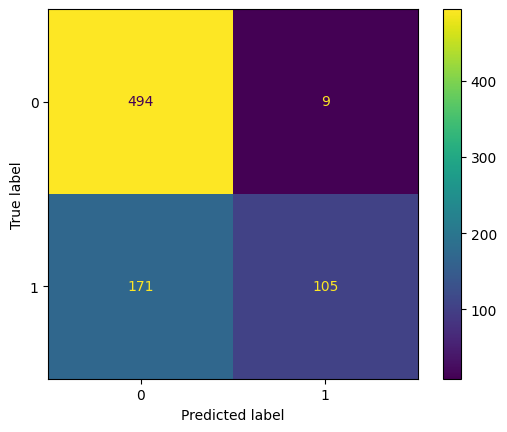

In [53]:
ConfusionMatrixDisplay.from_estimator(model, X_test_full, y_test)

The length of the review did not weild good results for us which is not too surprising with a correlation value so minimal. 